# Lab - Decision Tree & Random Forest
In this lab, we will apply Tree-based models to the California Housing dataset. We will explore:
1. **Decision Trees**: Single tree construction, visualization, and pruning.
2. **Random Forests**: Ensemble learning with Bagging and OOB evaluation.
3. **Feature Importance**: Interpreting what the model learned.

## 1. Introduction & Setup
In this section, we load the [California housing dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html) and perform initial exploration.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

# Basic Info
print(housing.DESCR.split('\n')[0:10]) # Print first few lines of description
print(f"Shape: {df.shape}")

['.. _california_housing_dataset:', '', 'California Housing dataset', '--------------------------', '', '**Data Set Characteristics:**', '', ':Number of Instances: 20640', '', ':Number of Attributes: 8 numeric, predictive attributes and the target']
Shape: (20640, 9)


## 2. Visualization
Before modeling, we must understand the feature distributions and correlations.

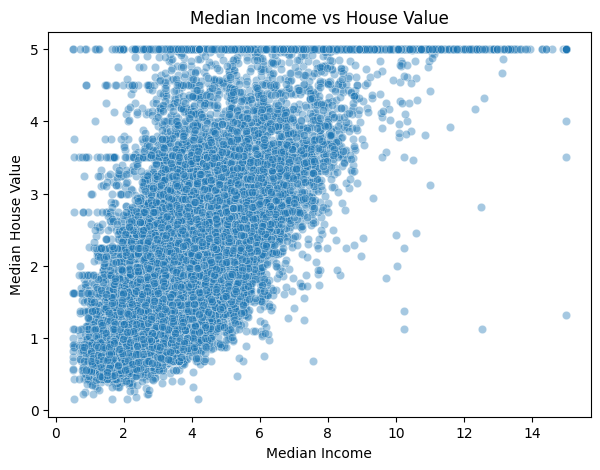

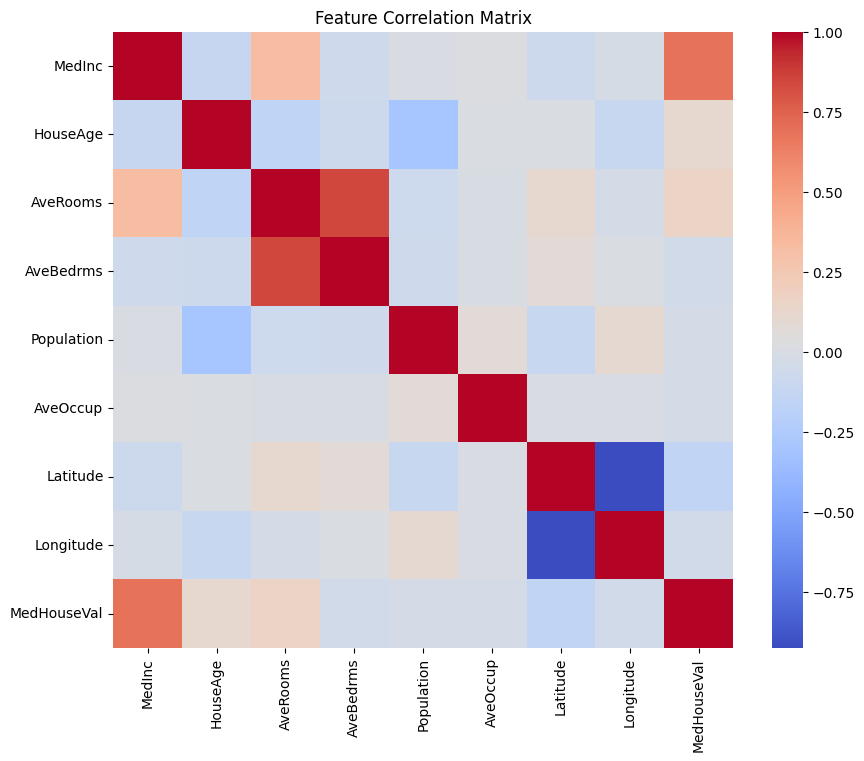

In [50]:
# Visualize interesting features, e.g., Median Income vs Price
import seaborn as sns
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['MedInc'], y=df['MedHouseVal'], alpha=0.4)
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Median Income vs House Value')
plt.show()

# Quick correlation heatmap for feature overview
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 3. Data preprocessing
Note: Unlike KNN or Linear Models, Trees do not strictly require feature scaling. You can try to scale the data and see if there are differences.

In [51]:
# Prepare data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop(columns='MedHouseVal') #feature
y = df['MedHouseVal'] #target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convenience DataFrames (optional)
X_train_s = pd.DataFrame(X_train, columns=X.columns, index=X_train.index)
X_test_s = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)
X_train_s.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


## 4. Decision Tree
We will start with a single **Decision Tree Regressor**. 
As discussed in the lecture, decision trees split data based on feature values to reduce node impurity (Variance/MSE for regression).

We will verify the impact of **Pruning** (controlling tree complexity) by setting `max_depth`.

Decision Tree Performance:
Train RMSE: 0.5172 | Test RMSE: 0.6424
Train R²: 0.7999 | Test R²: 0.6851


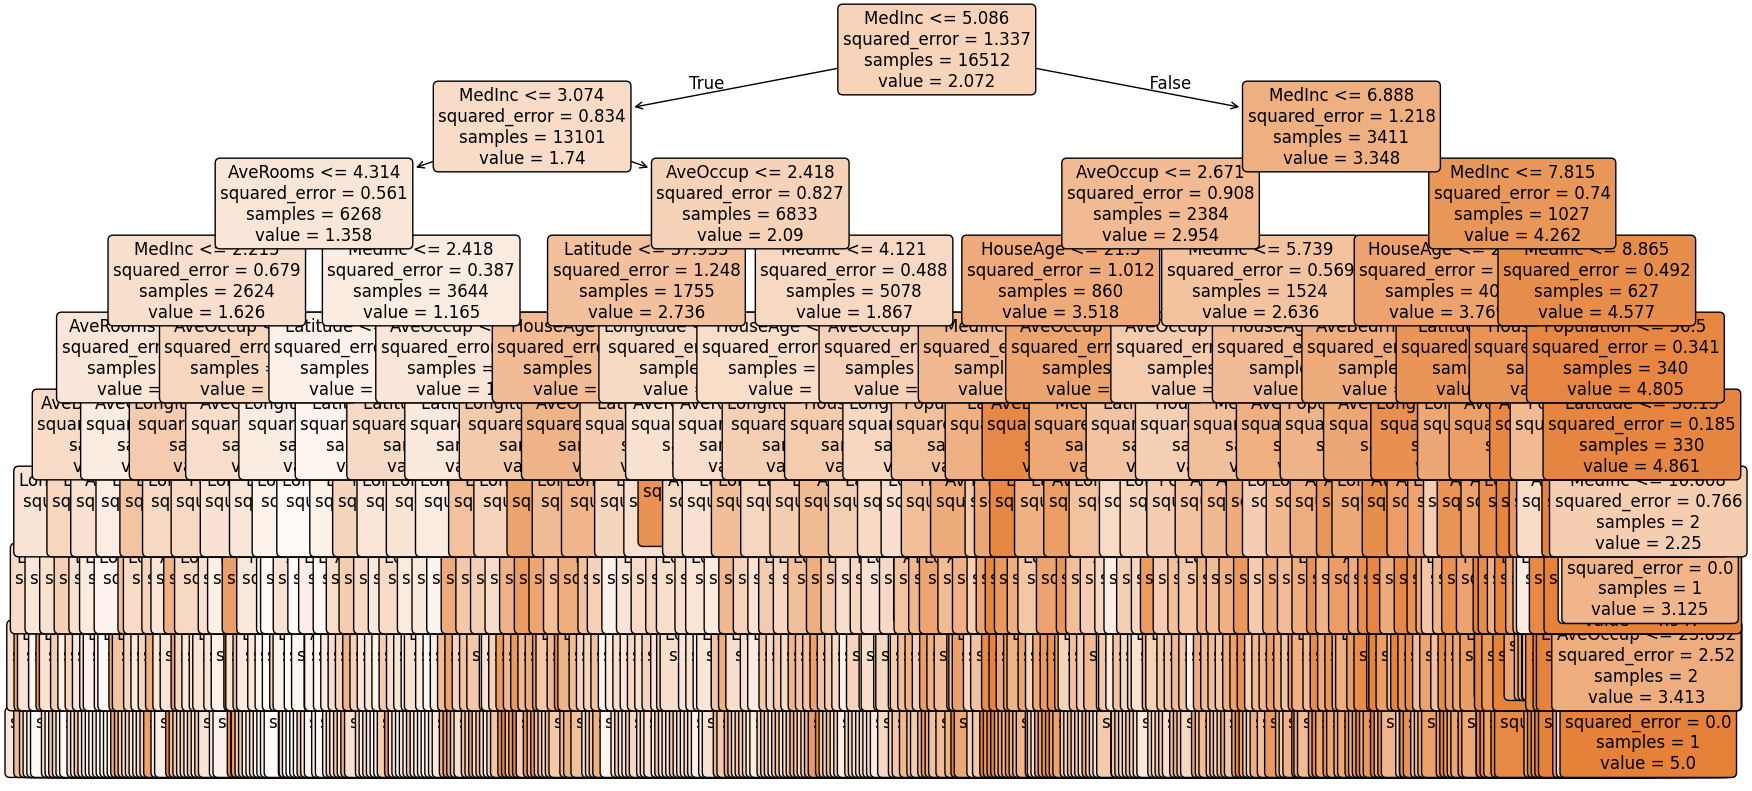

In [52]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Train a "Pre-pruned" Tree to avoid overfitting (Lecture Slide 31)
# We limit max_depth to keep the model interpretable and reduce variance

decision_tree = DecisionTreeRegressor(random_state=0, max_depth=9)
decision_tree.fit(X_train, y_train)

# Make predictions
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Decision Tree Performance:")
print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")


# 2. Visualize the Tree (Lecture Slide 29)

plt.figure(figsize = (20, 10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=12)
plt.savefig('housing_dt.png', format='png') # save plot to .png
plt.show()

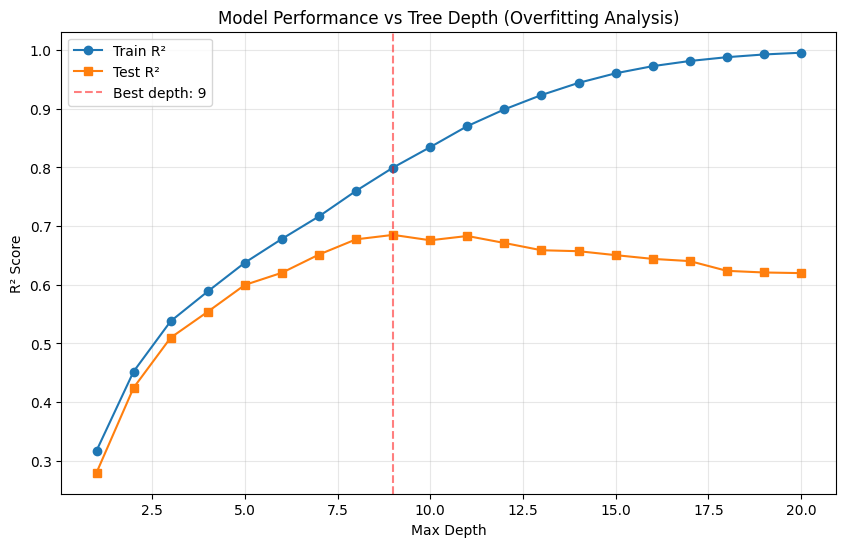

Best depth: 9
Best test R²: 0.6851


In [53]:
# Test different depths to visualize overfitting
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    dt = DecisionTreeRegressor(random_state=0, max_depth=depth)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    
    train_scores.append(r2_score(y_train, train_pred))
    test_scores.append(r2_score(y_test, test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Train R²', marker='o')
plt.plot(depths, test_scores, label='Test R²', marker='s')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Model Performance vs Tree Depth (Overfitting Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=depths[test_scores.index(max(test_scores))], 
            color='red', linestyle='--', alpha=0.5, 
            label=f'Best depth: {depths[test_scores.index(max(test_scores))]}')
plt.legend()
plt.show()

print(f"Best depth: {depths[test_scores.index(max(test_scores))]}")
print(f"Best test R²: {max(test_scores):.4f}")

## 5. Random Forest (Bagging)
A single tree often suffers from high variance (overfitting). As per the lecture, **Random Forest** improves generalization by creating a "forest" of trees using:
* **Row Bagging**: Bootstrapped subsets of data.
* **Feature Bagging**: Random subsets of features at each split.

We will also calculate the **Out-of-Bag (OOB) Score** (Lecture Slide 53), which acts as a built-in validation metric.

Random Forest Performance:
Train RMSE: 0.4171 | Test RMSE: 0.5432
Train R²: 0.8699 | Test R²: 0.7749
OOB R² Score: 0.7848


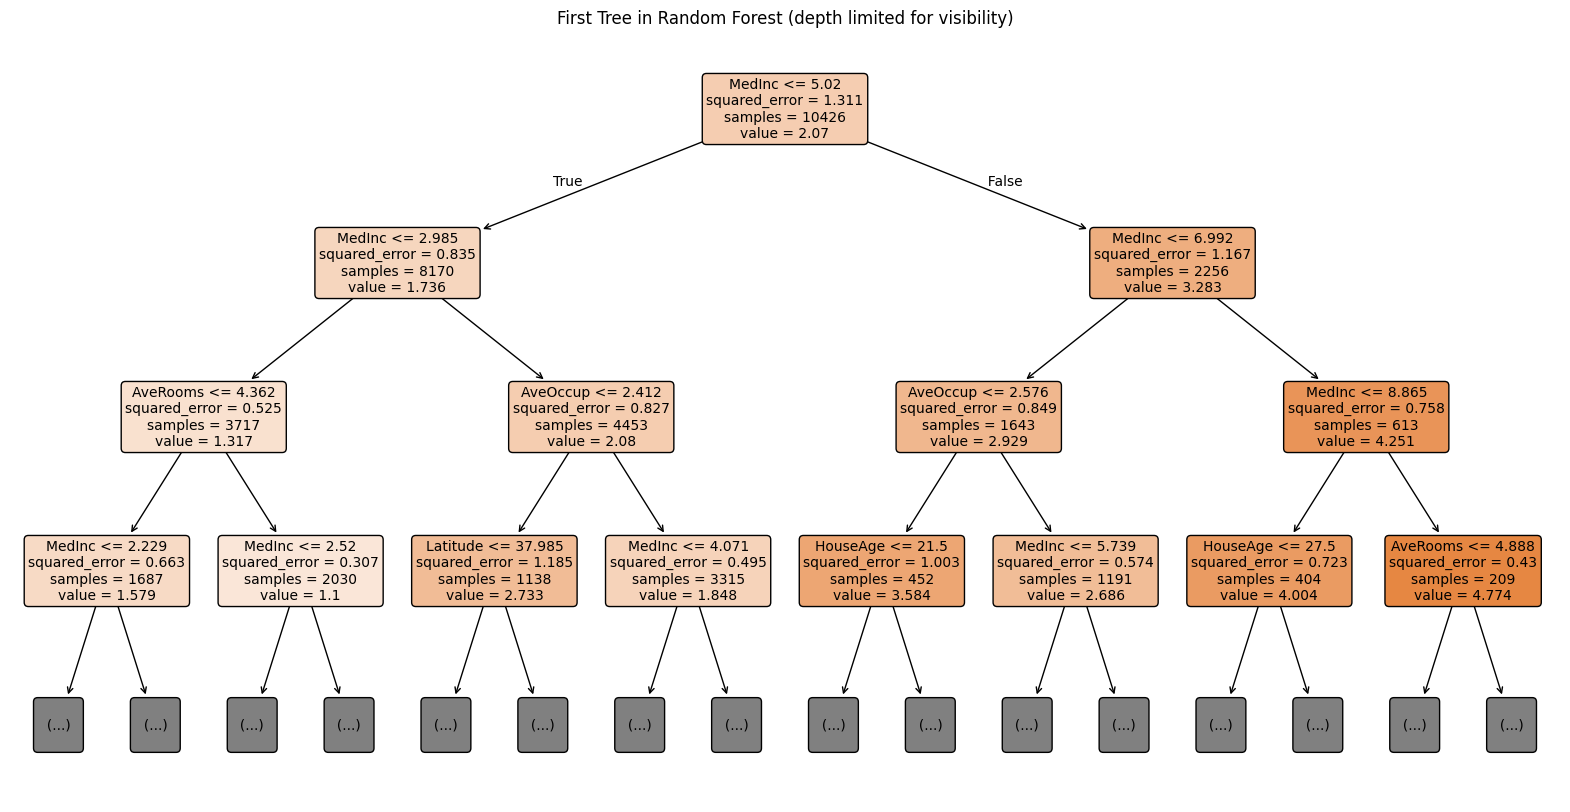

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
# n_estimators: Number of trees in the forest (Lecture Slide 50)
# oob_score: Use samples not selected for training to validate (Lecture Slide 54)
random_forest = RandomForestRegressor(n_estimators=150, random_state=0, oob_score=True, max_depth=10, min_samples_split=5)
random_forest.fit(X_train, y_train)

# Predictions
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)


# Evaluate performance
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("Random Forest Performance:")
print(f"Train RMSE: {train_rmse_rf:.4f} | Test RMSE: {test_rmse_rf:.4f}")
print(f"Train R²: {train_r2_rf:.4f} | Test R²: {test_r2_rf:.4f}")
print(f"OOB R² Score: {random_forest.oob_score_:.4f}")

# Visualize one tree from the forest (e.g., the first tree)
plt.figure(figsize=(20, 10))
plot_tree(random_forest.estimators_[0], filled=True, feature_names=X.columns, 
          rounded=True, fontsize=10, max_depth=3)
plt.title('First Tree in Random Forest (depth limited for visibility)')
plt.savefig('housing_rf_tree0.png', format='png')
plt.show()

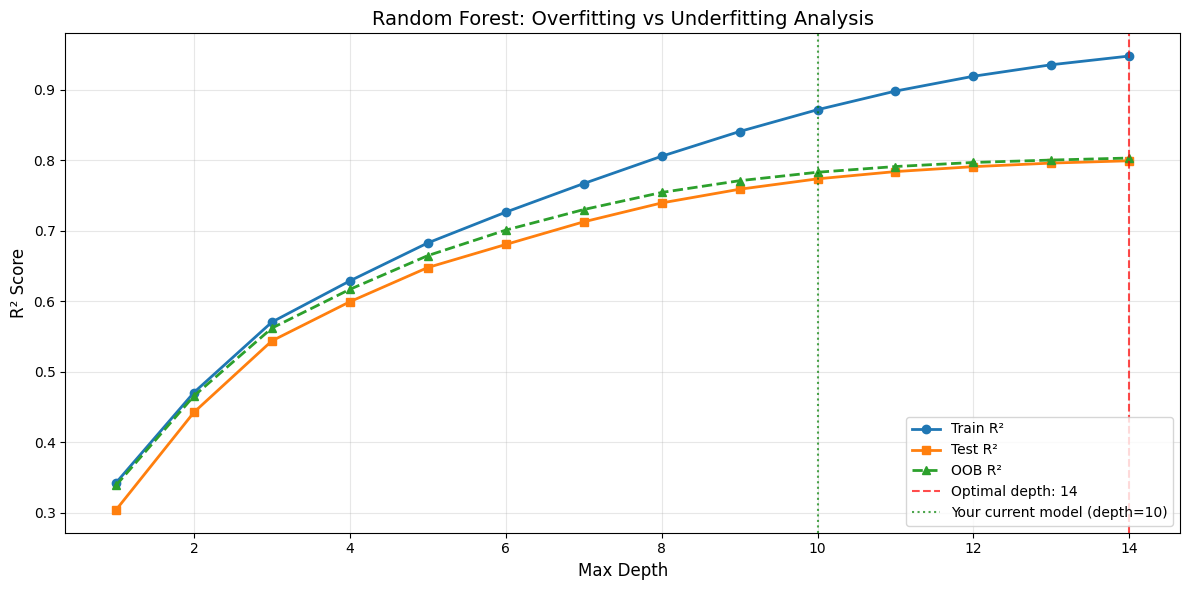

Optimal max_depth: 14
Best Test R²: 0.7995
Gap at optimal: 0.1486


In [55]:
# Test different max_depth values to visualize overfitting/underfitting
depths = range(1, 15)
train_scores_rf = []
test_scores_rf = []
oob_scores_rf = []

for depth in depths:
    rf = RandomForestRegressor(n_estimators=100, max_depth=depth, 
                               random_state=0, oob_score=True)
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)
    
    train_scores_rf.append(r2_score(y_train, train_pred))
    test_scores_rf.append(r2_score(y_test, test_pred))
    oob_scores_rf.append(rf.oob_score_)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(depths, train_scores_rf, label='Train R²', marker='o', linewidth=2)
plt.plot(depths, test_scores_rf, label='Test R²', marker='s', linewidth=2)
plt.plot(depths, oob_scores_rf, label='OOB R²', marker='^', linewidth=2, linestyle='--')

# Mark optimal depth
best_idx = test_scores_rf.index(max(test_scores_rf))
best_depth = depths[best_idx]
plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal depth: {best_depth}')

# Mark current model
plt.axvline(x=10, color='green', linestyle=':', alpha=0.7, 
            label='Your current model (depth=10)')

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Random Forest: Overfitting vs Underfitting Analysis', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal max_depth: {best_depth}")
print(f"Best Test R²: {max(test_scores_rf):.4f}")
print(f"Gap at optimal: {train_scores_rf[best_idx] - test_scores_rf[best_idx]:.4f}")

## 6. Feature Importance
One major advantage of Tree-based models is interpretability regarding which features matter most.
We calculate importance by checking how much splitting on a feature reduces impurity across all trees (Lecture Slide 55).

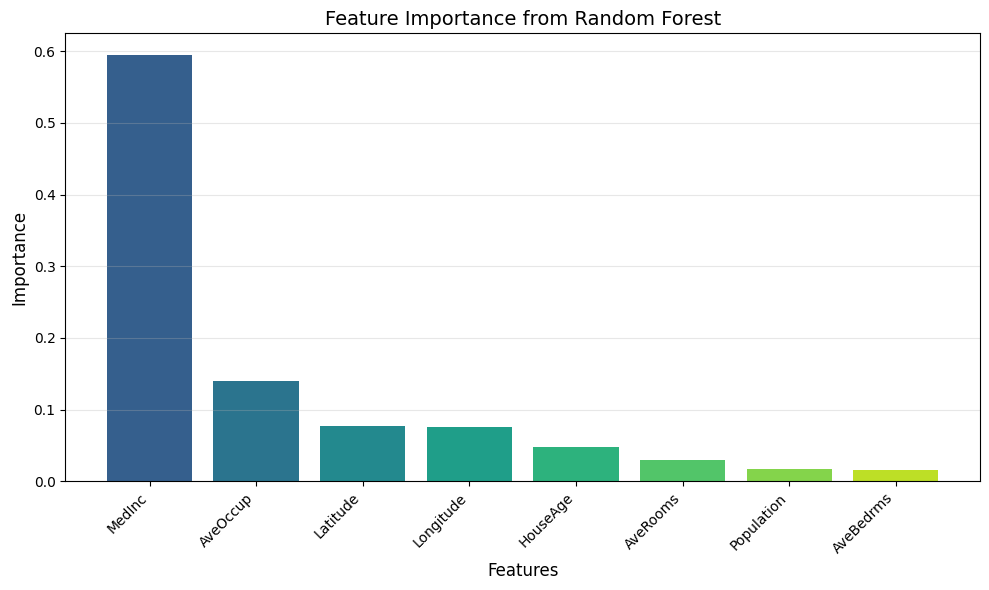


Top 3 Most Important Features:
1. MedInc: 0.5954
6. AveOccup: 0.1403
7. Latitude: 0.0772


In [56]:
# Calculate feature importances (Lecture Slide 56)

importances = random_forest.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot feature importances with color gradient
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importances)))
plt.bar(range(len(importances)), feature_importance_df['importance'], color=colors)
plt.xticks(range(len(importances)), feature_importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display top 3 features
print("\nTop 3 Most Important Features:")
for idx, row in feature_importance_df.head(3).iterrows():
    print(f"{idx+1}. {row['feature']}: {row['importance']:.4f}")

## 7. Evaluation

MODEL COMPARISON: Decision Tree vs Random Forest
        Model  Train RMSE  Test RMSE  Train R²  Test R²  Overfitting Gap
Decision Tree    0.517161   0.642393  0.799926 0.685084         0.114842
Random Forest    0.417109   0.543174  0.869852 0.774851         0.095001


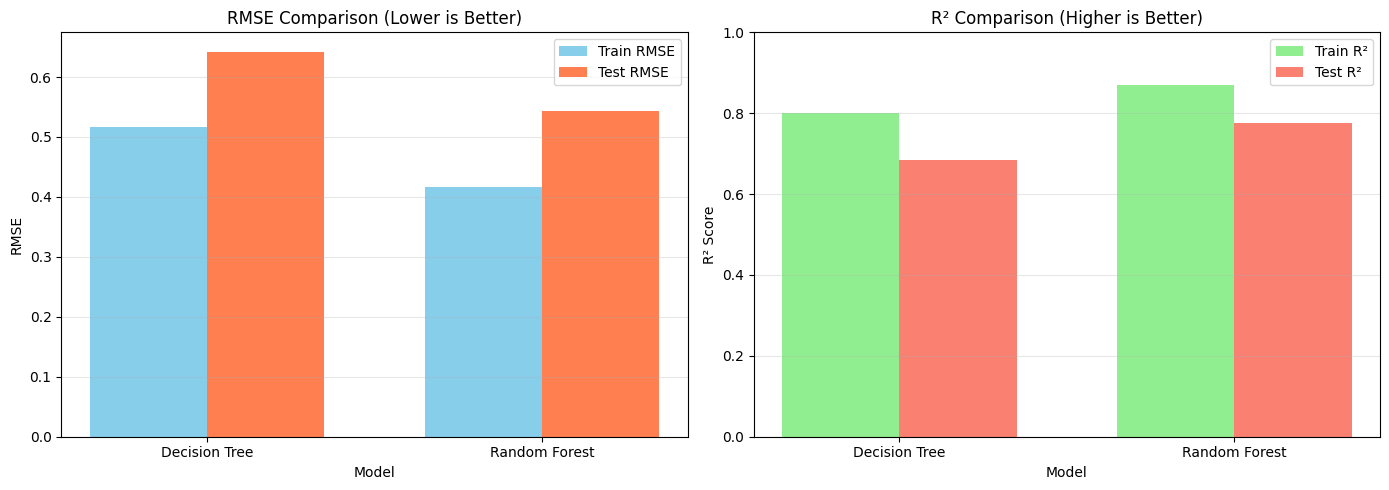


 KEY INSIGHTS:
✓ Random Forest improves test R² by 0.0898
✓ Random Forest reduces overfitting gap by 0.0198
✓ Best model for deployment: Random Forest


In [57]:
# Compare Single Tree vs Random Forest
# Compare Single Tree vs Random Forest

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Train RMSE': [train_rmse, train_rmse_rf],
    'Test RMSE': [test_rmse, test_rmse_rf],
    'Train R²': [train_r2, train_r2_rf],
    'Test R²': [test_r2, test_r2_rf],
    'Overfitting Gap': [train_r2 - test_r2, train_r2_rf - test_r2_rf]
})

print("="*70)
print("MODEL COMPARISON: Decision Tree vs Random Forest")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE Comparison
models = ['Decision Tree', 'Random Forest']
train_rmse_vals = [train_rmse, train_rmse_rf]
test_rmse_vals = [test_rmse, test_rmse_rf]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_rmse_vals, width, label='Train RMSE', color='skyblue')
axes[0].bar(x + width/2, test_rmse_vals, width, label='Test RMSE', color='coral')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R² Comparison
train_r2_vals = [train_r2, train_r2_rf]
test_r2_vals = [test_r2, test_r2_rf]

axes[1].bar(x - width/2, train_r2_vals, width, label='Train R²', color='lightgreen')
axes[1].bar(x + width/2, test_r2_vals, width, label='Test R²', color='salmon')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Comparison (Higher is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Key insights
print("\n KEY INSIGHTS:")
print(f"✓ Random Forest {'improves' if test_r2_rf > test_r2 else 'reduces'} test R² by {abs(test_r2_rf - test_r2):.4f}")
print(f"✓ Random Forest {'reduces' if train_r2_rf - test_r2_rf < train_r2 - test_r2 else 'increases'} overfitting gap by {abs((train_r2_rf - test_r2_rf) - (train_r2 - test_r2)):.4f}")
print(f"✓ Best model for deployment: {'Random Forest' if test_r2_rf > test_r2 else 'Decision Tree'}")